In [19]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

In [20]:
ny_set = 200 #670
nx_set = int(ny_set * 2)
@dataclass
class Config:
    nx: int = nx_set
    ny: int = ny_set
    steps: int = 50000
    output_stride: int = 3000
    molecular_weights: tuple[float, float, float] = (1, 1)
    pressure_frac: tuple[float, float, float] = (0.5, 0.5)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 9

    vx = 0.15
    record_flow = 100

In [21]:
def initialise_chamber(config: Config, absorption_coefficient, ini_slope):
    nx, ny = config.nx, config.ny
    species = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float32)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float32)
    pressure = xp.array(config.pressure_frac, dtype=xp.float32) * config.total_pressure
    for s in range(species):
        psigma[s, :, :] = pressure[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    ly = ny
    y_coord = xp.linspace(0.0, ly, ny)
    k = 2*xp.pi /ly
    velocity_profile = xp.sin(k*y_coord) * config.vx

    f = xp.zeros((species, 9, nx, ny), dtype=xp.float32)
    ux_s = xp.ones((species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float32)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [22]:
def main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, ini_slope, Config):
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_chamber(cfg, absorption_coefficient, ini_slope)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float32)

    velocity_field = []
    for step in tqdm(range(cfg.steps + 1)):
        #f_old = xp.copy(f)

        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 0.15, skip = 10, save = False)

        if step % cfg.record_flow == 0:
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            np.save(f"shear_flow", np.array(velocity_field))

        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream, step,
                     non_absorb_mask, bc_top, bc_bottom)

    return f

  0%|          | 0/50001 [00:00<?, ?it/s]

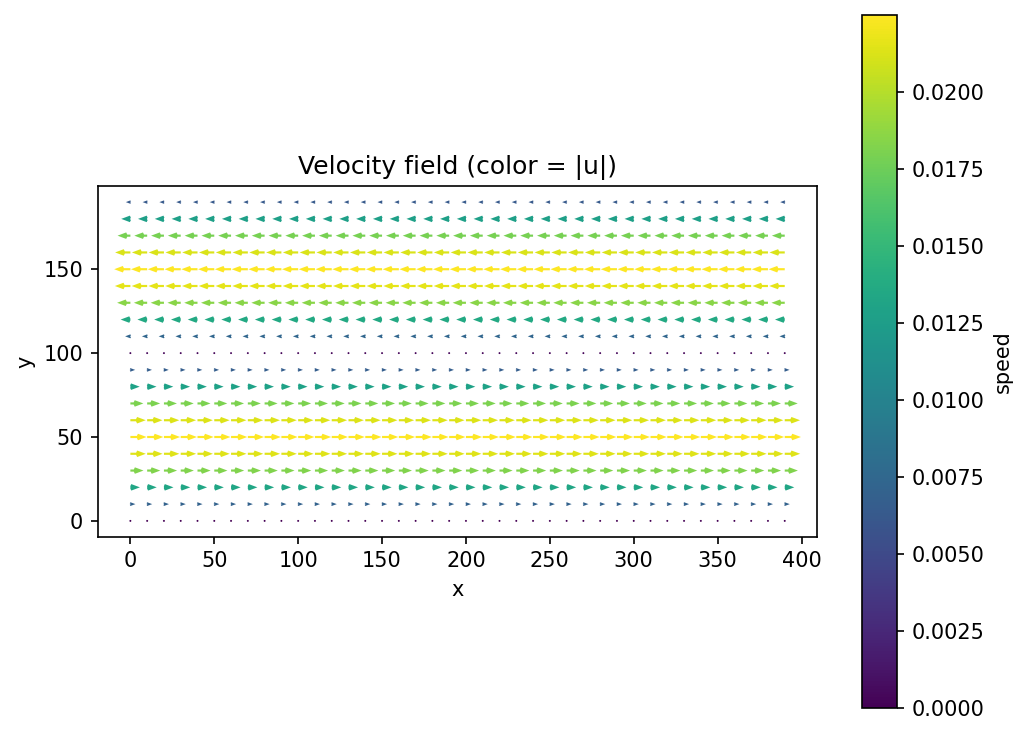

  6%|▌         | 2996/50001 [00:40<10:00, 78.23it/s]

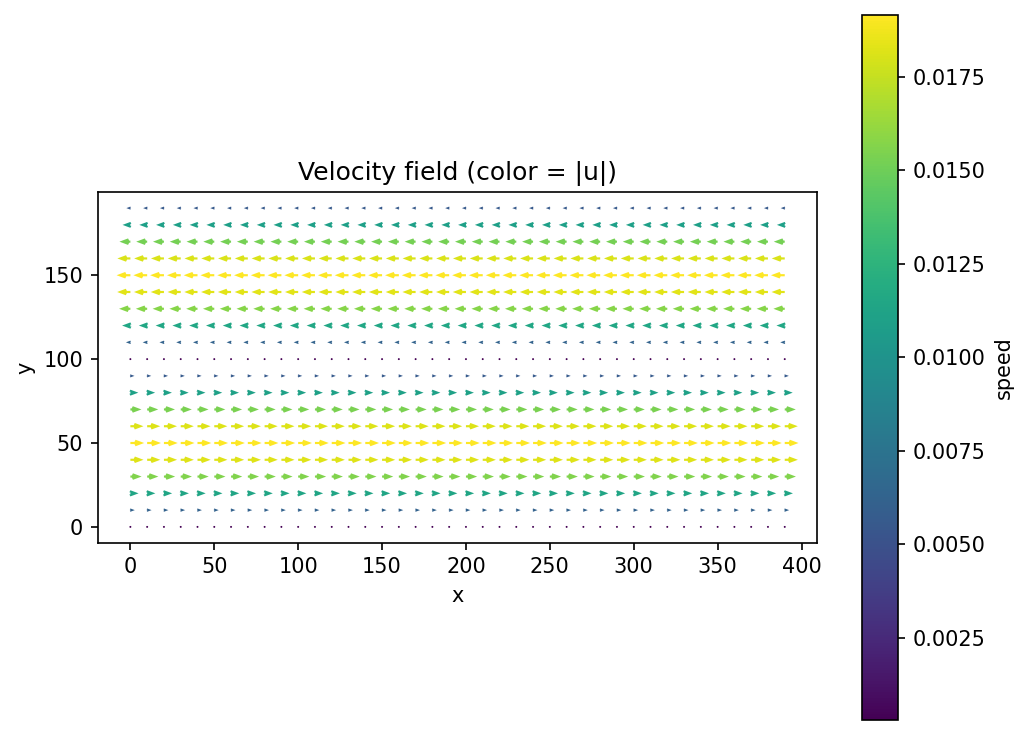

 12%|█▏        | 5993/50001 [01:21<09:27, 77.59it/s]

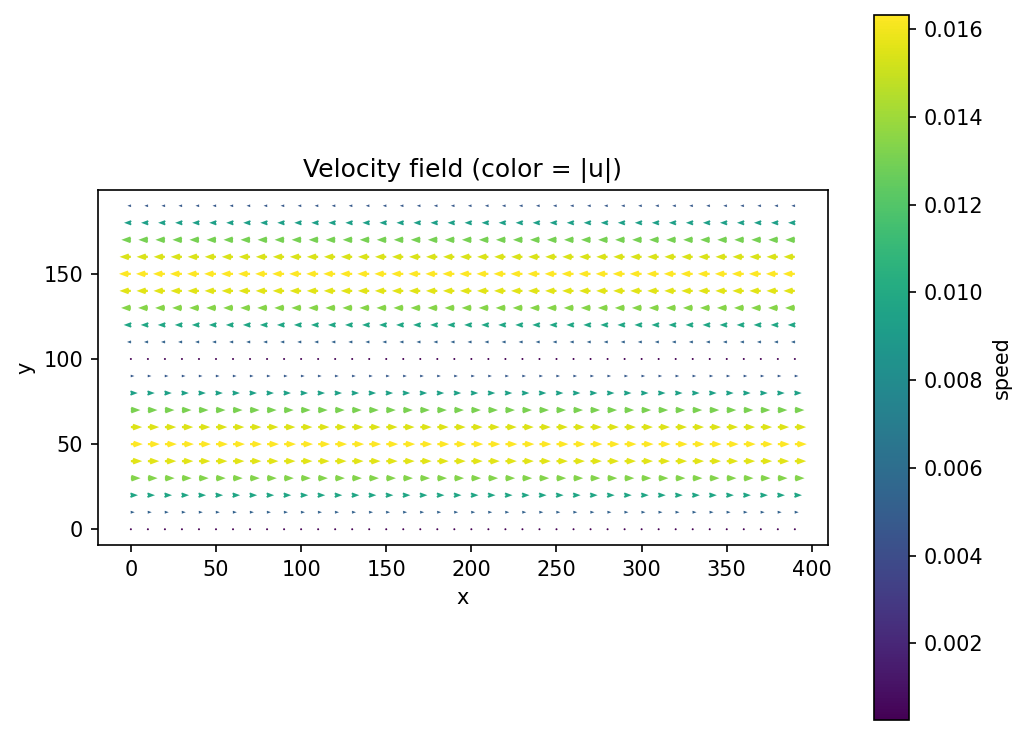

 18%|█▊        | 8998/50001 [02:03<08:37, 79.22it/s]

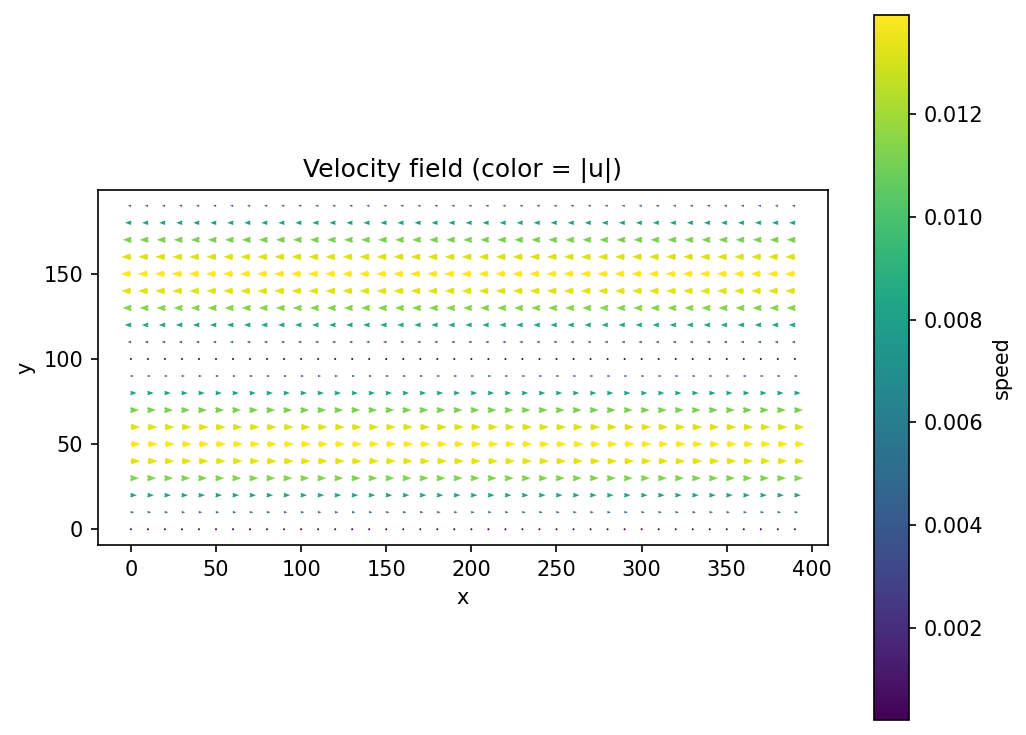

 24%|██▍       | 11993/50001 [02:43<08:46, 72.23it/s]

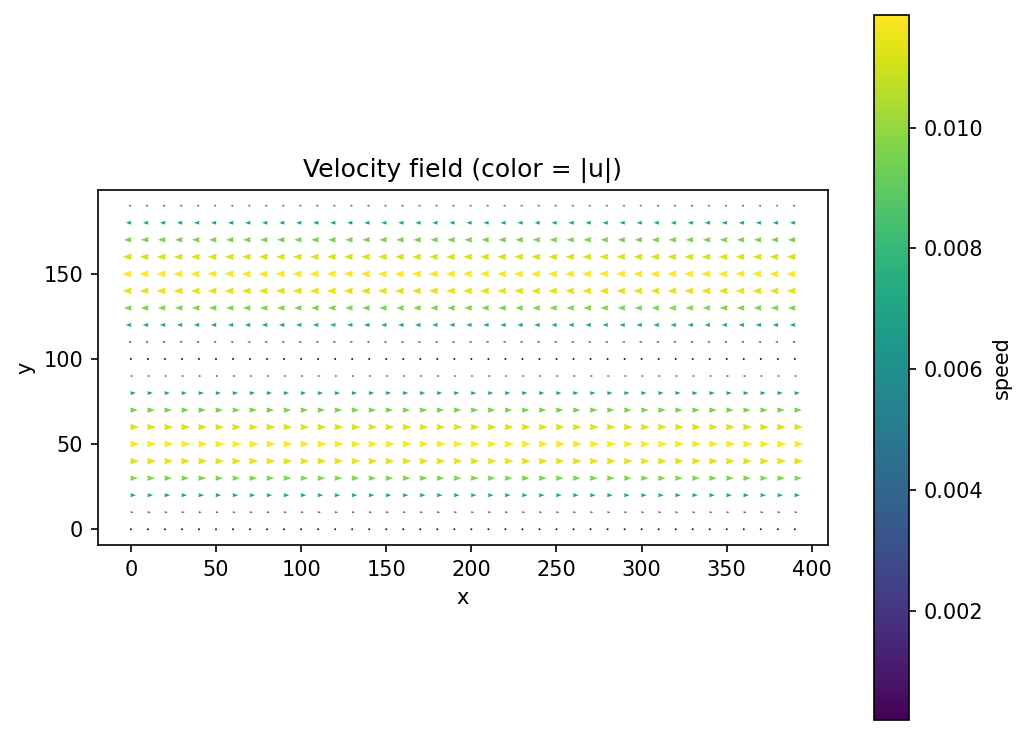

 30%|██▉       | 14993/50001 [03:28<08:21, 69.84it/s]

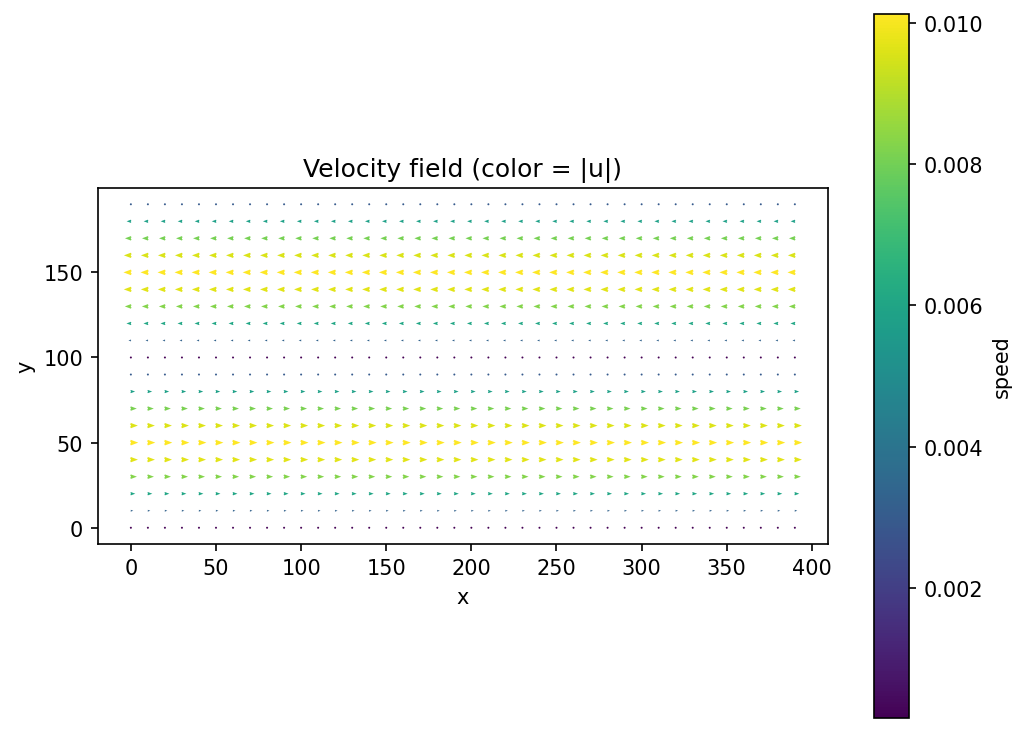

 30%|███       | 15192/50001 [03:32<08:06, 71.59it/s]


KeyboardInterrupt: 

In [23]:
absorption_coefficient = 100
bc_top = None
bc_bottom = None
non_absorb_mask = None

f= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)

In [24]:
shear_flow = np.load("shear_flow.npy")

In [25]:
print(shear_flow.shape)
# frames, components, species, nx, ny
vx_profile = shear_flow[:, 0, 0, nx_set//2, :]
print(vx_profile.shape)

(152, 2, 2, 400, 200)
(152, 200)


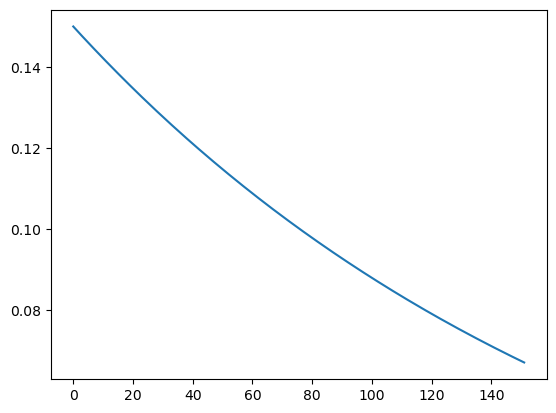

In [26]:
max_velocity_decay_profile = np.max(vx_profile, axis=1)
plt.plot(max_velocity_decay_profile)

In [27]:
ly = ny_set
k = 2*xp.pi /ly
i = len(max_velocity_decay_profile)-1
t = i * Config.record_flow
mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k**2)
print(mu)

0.053963793131613286


0.0541528673575402


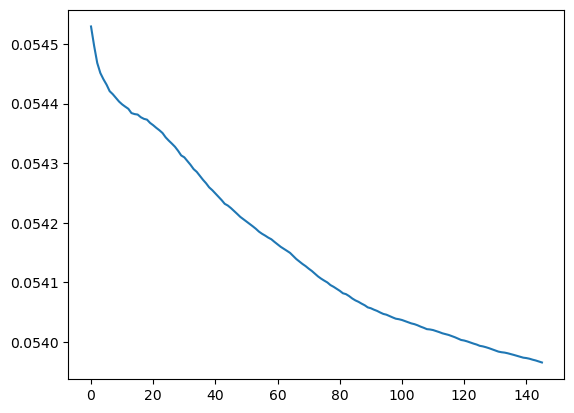

In [29]:
mu_lsit = []
for i in range(5, len(max_velocity_decay_profile)-1):
    t = i * Config.record_flow
    mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k**2)
    mu_lsit.append(mu)
plt.plot(mu_lsit)
print(np.mean(mu_lsit))

In [30]:
nb_table = np.array([0.50,0.60,0.72,0.87,1.05,1.26,1.51,1.82,2.19,2.63,3.16,3.80,4.57,5.49,6.61,7.95,9.56,11.5,13.8,16.6,], dtype = np.float32)
predict_lambda = 10 * nb_table[Config.nB] * (1/Config.molecular_weights[0]/3) * 1/np.sqrt(1/Config.molecular_weights[0] + 1/Config.molecular_weights[0])
print('lambda = ',predict_lambda)

relaxation = predict_lambda/(1+predict_lambda/2)
print('relaxation = ',relaxation)

viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)


lambda =  6.198969718141896
relaxation =  1.5121338244305034
viscosity_kinematic =  0.05377237645762337


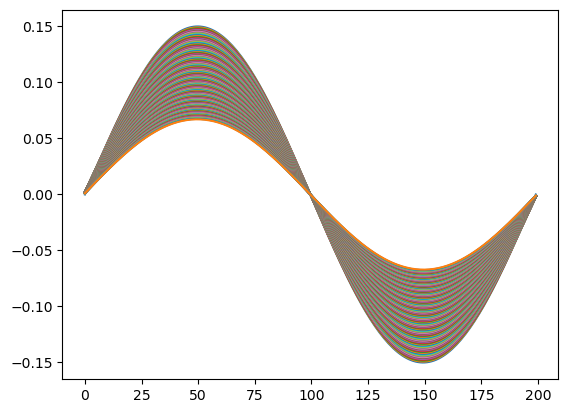

In [31]:
for i in range(shear_flow.shape[0]):
    plt.plot(vx_profile[i])